# Vanilla Prototypical Networks

## Download datasets

The mini-ImageNet dataset was provided by [Ren et al](https://arxiv.org/abs/1803.00676). They created the pickle files for train, validation and test. It can be found in their [few-shot-ssl-public](https://github.com/renmengye/few-shot-ssl-public) repository. But, in order to use the dataset, I copied the files to my drive, so it can be downloaded here: [mini-ImageNet](https://drive.google.com/uc?id=1GUDPuoH3JfbGR078vsuF5UFHuJTGXGFb&export=download).

The splits follow the procedure of [Ravi and Larochelle](https://openreview.net/forum?id=rJY0-Kcll).

The Omniglot dataset was provided by [Brenden Lake](https://github.com/brendenlake). However there were no pickle files that followed the exact procedure of [Vinyals et al](https://arxiv.org/abs/1606.04080) available. I decided to create the files myself using the split files provided by [Jake Snell](https://github.com/jakesnell/prototypical-networks).

The dataset can be download here: [Omniglot](https://drive.google.com/u/0/uc?id=1ny3lCPETCLbcjSQHPc3aANUcNR82Aht5&export=download).

Since the datasets are stored in Goodle Drive, I'll use gdown module to download them automatically.

First, let's **install** gdown module using pip3.

In [ ]:
!pip3 install gdown

### Omniglot

Create a directory to store Omniglot data and results.

In [1]:
!mkdir -p omniglot
!mkdir -p omniglot/data

data_dir = "omniglot/data"

**Download** the dataset.

In [2]:
!gdown -O $data_dir/omniglot.tar.gz "https://drive.google.com/u/0/uc?id=1ny3lCPETCLbcjSQHPc3aANUcNR82Aht5&export=download"

Downloading...
From: https://drive.google.com/u/0/uc?id=1ny3lCPETCLbcjSQHPc3aANUcNR82Aht5&export=download
To: /home/jupyter/prototypical_networks/vanilla_prototypical_network/omniglot/data/omniglot.tar.gz
6.31MB [00:00, 121MB/s]


**Extract** the images.

In [3]:
!tar -xvf $data_dir/omniglot.tar.gz -C $data_dir
!rm -f $data_dir/omniglot.tar.gz

test.pkl
train.pkl
valid.pkl


### mini-ImageNet

Create a directory to store mini-ImageNet data and results.

In [4]:
!mkdir -p mini_imagenet
!mkdir -p mini_imagenet/data

data_dir = "mini_imagenet/data"

**Download** the dataset.

In [5]:
!gdown -O $data_dir/miniImageNet.tar.gz "https://drive.google.com/uc?id=1GUDPuoH3JfbGR078vsuF5UFHuJTGXGFb&export=download"

Downloading...
From: https://drive.google.com/uc?id=1GUDPuoH3JfbGR078vsuF5UFHuJTGXGFb&export=download
To: /home/jupyter/prototypical_networks/vanilla_prototypical_network/mini_imagenet/data/miniImageNet.tar.gz
1.08GB [00:04, 250MB/s] 


**Extract** the images.

In [6]:
!tar -xvf $data_dir/miniImageNet.tar.gz -C $data_dir
!rm -f $data_dir/miniImageNet.tar.gz

!mv $data_dir/mini-imagenet-cache-train.pkl $data_dir/train.pkl
!mv $data_dir/mini-imagenet-cache-val.pkl $data_dir/valid.pkl
!mv $data_dir/mini-imagenet-cache-test.pkl $data_dir/test.pkl

mini-imagenet-cache-train.pkl
mini-imagenet-cache-val.pkl
mini-imagenet-cache-test.pkl


## Image Loader

Here we are loading the images from the pkl files to the respective lists.

Each file correspond to a image set.

For each set, we're going to create two lists: one for the images (the x) and one for the labels (the y).

**Import** some modules.

In [1]:
import pickle
import cv2
import numpy as np

from tqdm.notebook import trange, tqdm

**Function** to load images and their labels from a pkl file. 


In [2]:
# file_name -> path + name of the file
def load_images(file_name):
    # get file content
    with open(file_name, 'rb') as f:
        info = pickle.load(f)

    img_data = info['image_data']
    class_dict = info['class_dict']

    # create arrays to store x and y of images
    images = [] # x
    labels = [] # y
  
    # loop over all images and store them
    loading_msg = 'Reading images from %s' % file_name

    # loop over all classes
    for item in tqdm(class_dict.items(), desc = loading_msg):
        # loop over all examples from the class
        for example_num in item[1]:
            # convert image to RGB color channels
            RGB_img = cv2.cvtColor(img_data[example_num], cv2.COLOR_BGR2RGB)

            # store image and corresponding label
            images.append(RGB_img)
            labels.append(item[0])
  
    # return set of images
    return np.array(images), np.array(labels)

## Episode extractor

**Import** some modules.

In [3]:
import numpy as np

import torch
import torchvision

import matplotlib.pyplot as plt

**Function** to generate one episode.

In [4]:
# img_set_x -> images
# img_set_y -> labels
# num_way -> number of classes for episode
# num_shot -> number of examples per class
# num_query -> number of query examples per class 
def extract_episode(img_set_x, img_set_y, num_way, num_shot, num_query):
    # get a list of all unique labels (no repetition)
    unique_labels = np.unique(img_set_y)

    # select num_way classes randomly without replacement
    chosen_labels = np.random.choice(unique_labels, num_way, replace = False)
    # number of examples per selected class (label)
    examples_per_label = num_shot + num_query

    # list to store the episode
    episode = []

    # iterate over all selected labels 
    for label_l in chosen_labels:
        # get all images with a certain label l
        images_with_label_l = img_set_x[img_set_y == label_l]

        # suffle images with label l
        shuffled_images = np.random.permutation(images_with_label_l)

        # chose examples_per_label images with label l
        chosen_images = shuffled_images[:examples_per_label]

        # add the chosen images to the episode
        episode.append(chosen_images)

    # turn python list into a numpy array
    episode = np.array(episode)

    # convert numpy array to tensor of floats
    episode = torch.from_numpy(episode).float()

    # reshape tensor (required)
    episode = episode.permute(0,1,4,2,3)

    # get the shape of the images
    img_dim = episode.shape[2:]
  
    # build a dict with info about the generated episode
    episode_dict = {
        'images': episode, 'num_way': num_way, 'num_shot': num_shot, 
        'num_query': num_query, 'img_dim': img_dim}

    return episode_dict

**Function** to display a grid representation of an episode.

In [5]:
# episode_dict -> dict with info about the chosen episode
def display_episode_images(episode_dict):
    # number of examples per class 
    examples_per_label = episode_dict['num_shot'] + episode_dict['num_query']

    # total number of images
    num_images = episode_dict['num_way'] * examples_per_label

    # select the images
    images = episode_dict['images'].view(num_images, *episode_dict['img_dim'])

    # create a grid with all the images
    grid_img = torchvision.utils.make_grid(images, nrow = examples_per_label)

    # reshape the tensor and convert to numpy array of integers 
    grid_img = grid_img.permute(1, 2, 0).numpy().astype(np.uint8)

    # chage image from BGR to RGB
    grid_img = cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB)

    # set a bigger size
    plt.figure(figsize = (80, 8))

    # remove the axis
    plt.axis('off')

    # plot the grid image
    plt.imshow(grid_img)

## Utility Functions

**Import** required modules.

In [6]:
import logging
import sys

from os import path, mkdir, remove

Here we have some utility functions like the metric used in the model.

### Euclidean Distance

Metric used to determine the distance between all query points and prototypes of an episode.

**Some explanations**

Consider a 20-way 5-shot problem with 15 query images per class. </br>
Suppose x (query embeddings) has a size [300, 1600] and y (prototypes) [20, 1600].

The unsqueeze function calls will transform the sizes of x and y. So, x will have a size [300, 1, 1600] and y [1, 20, 1600]. </br>
Then, the expand function calls will cause x to have a size [300, 20, 1600] and y a size [300, 20, 1600].

These transformations are required since x and y will be subtracted in pow function call. </br>
In other words, they need to have the same shape in order to calculate the distance.

Once they are in the same shape, pow function is called. </br>
The sum function will return a [300, 20] tensor with all the distances. 

Example: [i][j] is the distance between query embedding i and prototype j.

**Function** to calculate the euclidean distance between embeddings.

In [7]:
def euclidean_dist(x, y):
    elements_in_x = x.size(0)
    elements_in_y = y.size(0)

    dimension_elements = x.size(1)

    assert dimension_elements == y.size(1)

    x = x.unsqueeze(1).expand(elements_in_x , elements_in_y, dimension_elements)
    y = y.unsqueeze(0).expand(elements_in_x , elements_in_y, dimension_elements)

    distances = torch.pow(x - y, 2).sum(2)

    return distances

### Logger

Let's **configure** the logger.

In [8]:
console_logging_format = "%(message)s"

logging.basicConfig(stream = sys.stdout, level = logging.INFO, format = console_logging_format)

print(logging.getLogger().handlers)

[<StreamHandler stdout (NOTSET)>]


**Function** to remove old and add new handlers to logger.

In [9]:
def create_logger(log_dir, file_name):
    # get logger
    logger = logging.getLogger()
    
    # remove previous handlers, if they exist
    if bool(logger.handlers):
        logger.handlers.clear()
    
    # create a log directory, if not exists
    if not path.exists(log_dir):
        mkdir(log_dir)
    
    log_file_path = path.join(log_dir, file_name)
    
    # remove old log file (w/ same name)
    if path.exists(log_file_path):
        remove(log_file_path)
    
    # create a new log file
    f = open(log_file_path, 'w+')
    f.close()

    # create a file handler for output file
    file_handler = logging.FileHandler(log_file_path)
    file_handler.setLevel(logging.INFO)
    
    # configure message to log in file
    file_logging_format = "[%(levelname)s] %(asctime)s: %(message)s"
    formatter = logging.Formatter(file_logging_format)
    file_handler.setFormatter(formatter)
    
    # create a console handler
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.INFO)
    
    # configure message to log in console
    console_logging_format = "%(message)s"
    formatter = logging.Formatter(console_logging_format)
    console_handler.setFormatter(formatter)
    
    # add handlers to logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
    return logger

## Model

**Import** required modules.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

The model below computes a **class prototype** by **averaging the support embeddings of a class**.

In [11]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, episode_dict):
        # extract all images 
        images = episode_dict['images'].cuda()
        
        # get episode setup
        num_way = episode_dict['num_way'] # way
        num_shot = episode_dict['num_shot'] # shot
        num_query = episode_dict['num_query'] # number of query images
        
        # from each class, extract num_shot support images
        x_support = images[:, :num_shot] # lines are classes and columns are images
        
        # from each class, extract the remaining images as query images
        x_query = images[:, num_shot:] # lines are classes and columns are images
        
        # create indices from 0 to num_way-1 for classification
        target_inds = torch.arange(0, num_way).view(num_way, 1, 1)
        
        # replicate all indices num_query times (for each query image)
        target_inds = target_inds.expand(num_way, num_query, 1).long()
        
        # convert indices from Tensor to Variable
        target_inds = Variable(target_inds, requires_grad = False).cuda()
        
        # transform x_support into a array in which all images are contiguous
        x_support = x_support.contiguous().view(
            num_way * num_shot, *x_support.size()[2:]) # no more lines and columns
                
        # transform x_query into a array in which all images are contiguous
        x_query = x_query.contiguous().view(
            num_way * num_query, *x_query.size()[2:]) # no more lines and columns

        # join all images into a single contiguous array 
        x = torch.cat([x_support, x_query], 0)
        
        # encode all images
        z = self.encoder.forward(x) # embeddings
        
        # compute class prototypes
        z_dim = z.size(-1)
        z_proto = z[:(num_way * num_shot)].view(num_way, num_shot, z_dim).mean(1)
        
        # get the query embeddings
        z_query = z[(num_way * num_shot):]

        # compute distance between query embeddings and class prototypes
        dists = euclidean_dist(z_query, z_proto)
        
        # compute the log probabilities
        log_p_y = F.log_softmax(-dists, dim = 1).view(num_way, num_query, -1)
        
        # compute the loss
        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        
        # get the predicted labels for each query
        _, y_hat = log_p_y.max(2) # lines are classes and columns are query embeddings
        
        # compute the accuracy
        acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
        
        # return output: loss, acc and predicted value
        return loss_val, {
            'loss': loss_val.item(), 'acc': acc_val.item(), 'y_hat': y_hat}

**Function** to load the model.

In [12]:
# function to load the model structure
def load_protonet(x_dim, hid_dim, z_dim):
    # define a convolutional block
    def conv_block(layer_input, layer_output): 
        conv = nn.Sequential(
            nn.Conv2d(layer_input, layer_output, 3, padding=1),
            nn.BatchNorm2d(layer_output), nn.ReLU(), 
            nn.MaxPool2d(2))

        return conv
  
    # create the encoder to the embeddings for the images
    # the encoder is made of four conv blocks 
    encoder = nn.Sequential(
        conv_block(x_dim[0], hid_dim), conv_block(hid_dim, hid_dim), 
        conv_block(hid_dim, hid_dim), conv_block(hid_dim, z_dim), Flatten())
  
    return ProtoNet(encoder)

## For training and evaluating

**Import** required modules.

In [23]:
import torch.nn as nn
import torch.optim as optim

import numpy as np
from math import fsum

from tqdm.notebook import trange
from os import path, mkdir

**Choose** a dataset to train the model.

In [24]:
# Options: "omniglot" or "mini_imagenet"
dataset = "mini_imagenet"

**Load** train, validation and test sets.

In [25]:
data_dir = path.join(dataset, 'data')

train_x, train_y = load_images(path.join(data_dir,  'train.pkl'))
valid_x, valid_y = load_images(path.join(data_dir,  'valid.pkl'))
test_x, test_y = load_images(path.join(data_dir,  'test.pkl'))

Reading images from mini_imagenet/data/train.pkl:   0%|          | 0/64 [00:00<?, ?it/s]

Reading images from mini_imagenet/data/valid.pkl:   0%|          | 0/16 [00:00<?, ?it/s]

Reading images from mini_imagenet/data/test.pkl:   0%|          | 0/20 [00:00<?, ?it/s]

We can **check** the shape of our sets.

The shape will be ((n, w, d, c), (n,)), where:
* n is the number of images and corresponding labels;
* w is the width of the images;
* h is the height of the images;
* c is the number of color channels.

In [ ]:
train_x.shape, train_y.shape

In [ ]:
valid_x.shape, valid_y.shape

In [ ]:
test_x.shape, test_y.shape

**Generate** and **display** an episode to check if everything is okay.

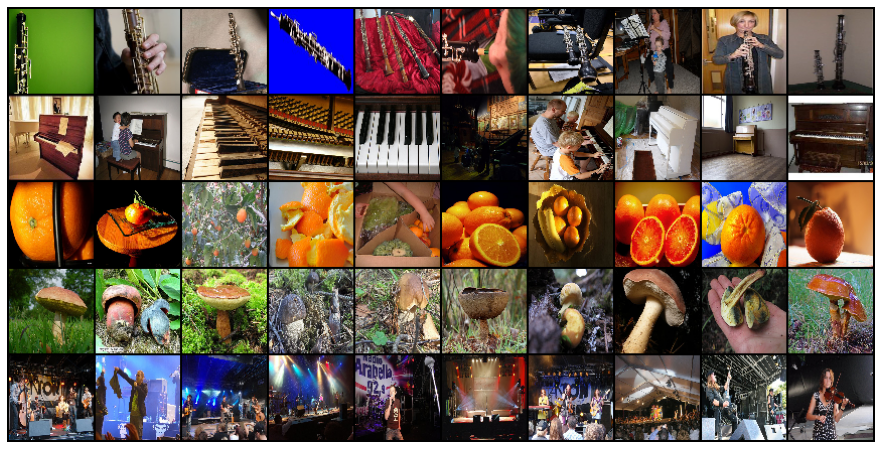

In [26]:
episode_dict = extract_episode(train_x, train_y, num_way = 5, num_shot = 5, num_query = 5)

display_episode_images(episode_dict)

**Create** a directory to store the time of execution and the results.

In [27]:
results_dir = path.join(dataset, 'results')

if not path.exists(results_dir):
    mkdir(results_dir)

**Set** hyperparameters and other parameters.

In [28]:
best_epoch = {
    'number': -1,
    'loss': np.inf,
    'acc': 0}

config = {
    'results_dir': results_dir,
    'learning_rate': 0.001,
    'decay_every': 20,
    'patience': 200,
    'best_epoch': best_epoch,
    'wait': 0,
    'stop': False}

**Load** model structure.

In [29]:
# images have 3 color channels and are 84 x 84
# Convolutional blocks have 64 filters
model = load_protonet(x_dim  = (3, 84, 84), hid_dim = 64, z_dim = 64)

## Train and evaluate

**Function** to train the model on the train set through many epochs.

At the end of each epoch, the model is evaluated on the validation set.

In [ ]:
# model -> model structure
# config -> dict with some hyperparameters and important configs
# train_data -> train set, num_way, num_shot, num_query etc
# valid_data -> validation set, num_way, num_shot, num_query etc
def train(model, config, train_data, valid_data, logger):
    # set Adam optimizer with an initial learning rate
    optimizer = optim.Adam(
        model.parameters(), lr = config['learning_rate'])

    # schedule learning rate to be cut in half every 2000 episodes
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, config['decay_every'], gamma = 0.5, last_epoch = -1)

    # set model to training mode
    model.train()

    # number of epochs so far
    epochs_so_far = 0

    # train until early stopping says so
    # or until the max number of epochs is not achived 
    while epochs_so_far < train_data['max_epoch'] and not config['stop']:
        epoch_loss = 0.0
        epoch_acc = 0.0

        logger.info('==> Epoch %d' % (epochs_so_far + 1))

        logger.info('> Training')

        # do epoch_size classification tasks to train the model
        for episode in trange(train_data['epoch_size']):
            # get the episode dict
            episode_dict = extract_episode(
              train_data['train_x'], train_data['train_y'], train_data['num_way'], 
              train_data['num_shot'], train_data['num_query'])

            optimizer.zero_grad()

            # classify images and get the loss and the acc of the curr episode
            loss, output = model.set_forward_loss(episode_dict)

            # acumulate the loss and the acc
            epoch_loss += output['loss']
            epoch_acc += output['acc']

            # update the model parameters (weights and biases)
            loss.backward()
            optimizer.step()

        # average the loss and the acc to get the epoch loss and the acc
        epoch_loss = epoch_loss / train_data['epoch_size']
        epoch_acc = epoch_acc / train_data['epoch_size']

        # output the epoch loss and the epoch acc
        logger.info('Loss: %.4f / Acc: %.2f%%' % (epoch_loss, (epoch_acc * 100)))

        # do one epoch of evaluation on the validation test
        evaluate_valid(model, config, valid_data, epochs_so_far + 1, logger)

        # increment the number of epochs
        epochs_so_far += 1

        # tell the scheduler to increment its counter
        scheduler.step()

    # get dict with info about the best epoch
    best_epoch = config['best_epoch']

    # at the end of the training, output the best loss and the best acc
    logger.info('Best loss: %.4f / Best Acc: %.2f%%' 
          % (best_epoch['loss'], (best_epoch['acc'] * 100)))

    # save dict with info about the best epoch
    with open(path.join(config['results_dir'], 'best_epoch.pkl'), 'wb') as f:
        pickle.dump(best_epoch, f, pickle.HIGHEST_PROTOCOL)

**Function** to evaluate the model on the validation set.

In [ ]:
# model -> model structure
# config -> dict with some hyperparameters and important configs
# valid_data -> validation set, num_way, num_shot, num_query etc
# epoch -> number of the respective training epoch
def evaluate_valid(model, config, valid_data, curr_epoch, logger):
    # set model to evaluation mode
    model.eval()

    valid_loss = 0.0
    valid_acc = 0.0

    logger.info('> Validation')

    # do epoch_size classification tasks to evaluate the model
    for episode in trange(valid_data['epoch_size']):
        # get the episode dict
        episode_dict = extract_episode(
            valid_data['valid_x'], valid_data['valid_y'], valid_data['num_way'], 
            valid_data['num_shot'], valid_data['num_query'])

        # classify images and get the loss and the acc of the curr episode
        _, output = model.set_forward_loss(episode_dict)

        # acumulate the loss and the acc
        valid_loss += output['loss']
        valid_acc += output['acc']
  
    # average the loss and the acc to get the valid loss and the acc
    valid_loss = valid_loss / valid_data['epoch_size']
    valid_acc = valid_acc / valid_data['epoch_size']

    # output the valid loss and the valid acc
    logger.info('Loss: %.4f / Acc: %.2f%%' % (valid_loss, (valid_acc * 100)))

    # implement early stopping mechanism
    # check if valid_loss is the best so far
    if config['best_epoch']['loss'] > valid_loss:
        # if true, save the respective train epoch
        config['best_epoch']['number'] = curr_epoch

        # save the best loss and the respective acc
        config['best_epoch']['loss'] = valid_loss
        config['best_epoch']['acc'] = valid_acc

        # save the model with the best loss so far
        model_file = path.join(config['results_dir'], 'best_model.pth')
        torch.save(model.state_dict(), model_file)

        logger.info('=> This is the best model so far! Saving...')

        # set wait to zero
        config['wait'] = 0
    else:
        # if false, increment the wait
        config['wait'] += 1

        # when the wait is bigger than the patience
        if config['wait'] > config['patience']:
            # the train has to stop
            config['stop'] = True

            logger.info('Patience was exceeded... Stopping...')

Now, let's **train** the model.

In [ ]:
if dataset == 'mini_imagenet':
    train_data = {
        'train_x': train_x,
        'train_y': train_y,
        'num_way': 20,
        'num_shot': 5,
        'num_query': 15,
        'max_epoch': 10000,
        'epoch_size': 100}
elif dataset == 'omniglot':
    train_data = {
        'train_x': train_x,
        'train_y': train_y,
        'num_way': 60,
        'num_shot': 5,
        'num_query': 5,
        'max_epoch': 10000,
        'epoch_size': 100}

valid_data = {
    'valid_x': valid_x,
    'valid_y': valid_y,
    'num_way': 5,
    'num_shot': 5,
    'num_query': 15,
    'epoch_size': 100}

train_logger = create_logger(path.join(dataset, 'logs'), 'train.log')

train_time = %timeit -n1 -r1 -q -o train(model, config, train_data, valid_data, train_logger)

train_logger.info('Time taken: ' + str(train_time))

**Check** best epoch number.

In [30]:
with open(path.join(config['results_dir'], 'best_epoch.pkl'), 'rb') as f:
    number = pickle.load(f)['number']

print(number)

495


## Train with train + valid sets

**Function** to retrain the model using both train and validation sets.

In [ ]:
# model -> model structure
# config -> dict with some hyperparameters and important configs
# retrain_data -> train + valid set, num_way, num_shot, num_query etc
def retrain(model, config, retrain_data, logger):
    # load the saved model
    state_dict = torch.load(path.join(config['results_dir'], 'best_model.pth'))
    model.load_state_dict(state_dict)

    # set Adam optimizer with an initial learning rate
    optimizer = optim.Adam(
      model.parameters(), lr = config['learning_rate'])

    # schedule learning rate to be cut in half every 2000 episodes
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, config['decay_every'], gamma = 0.5, last_epoch = -1)

    # set model to training mode
    model.train()

    # number of epochs so far
    epochs_so_far = 0

    # retrieve the epoch with best valid loss to determine max_epoch
    with open(path.join(config['results_dir'], 'best_epoch.pkl'), 'rb') as f:
        best_epoch_num = pickle.load(f)['number']
  
    max_epoch = best_epoch_num + 1#config['patience']
  
    while epochs_so_far < max_epoch:
        epoch_loss = 0.0
        epoch_acc = 0.0

        logger.info('==> Epoch %d' % (epochs_so_far + 1))

        # do epoch_size classification tasks to evaluate the model
        for episode in trange(retrain_data['epoch_size']):
            # get the episode dict
            episode_dict = extract_episode(
                retrain_data['retrain_x'], retrain_data['retrain_y'], 
                retrain_data['num_way'], retrain_data['num_shot'], 
                retrain_data['num_query'])
      
            optimizer.zero_grad()

            # classify images and get the loss and the acc of the curr episode
            loss, output = model.set_forward_loss(episode_dict)

            # acumulate the loss and the acc
            epoch_loss += output['loss']
            epoch_acc += output['acc']

            # update the model parameters (weights and biases)
            loss.backward()
            optimizer.step()

        # average the loss and the acc to get the epoch loss and the acc
        epoch_loss = epoch_loss / retrain_data['epoch_size']
        epoch_acc = epoch_acc / retrain_data['epoch_size']

        # output the epoch loss and the epoch acc
        logger.info('Loss: %.4f / Acc: %.2f%%' % (epoch_loss, (epoch_acc * 100)))

        # increment the number of epochs
        epochs_so_far += 1

        # tell the scheduler to increment its counter
        scheduler.step()

    # save a model better than the previous one
    torch.save(
        model.state_dict(), 
        path.join(config['results_dir'], 'best_model.pth'))

Let's **retrain** the model.

In [ ]:
if dataset == 'mini_imagenet':
    retrain_data = {
        'retrain_x': np.concatenate((train_x, valid_x)),
        'retrain_y': np.concatenate((train_y, valid_y)),
        'num_way': 20,
        'num_shot': 5,
        'num_query': 15,
        'epoch_size': 100}
elif dataset == 'omniglot':    
    retrain_data = {
        'retrain_x': np.concatenate((train_x, valid_x)),
        'retrain_y': np.concatenate((train_y, valid_y)),
        'num_way': 60,
        'num_shot': 5,
        'num_query': 5,
        'epoch_size': 100}
    
retrain_logger = create_logger(path.join(dataset, 'logs'), 'retrain.log')

retrain_time = %timeit -n1 -r1 -q -o retrain(model, config, retrain_data, retrain_logger)

retrain_logger.info('Time taken: ' + str(retrain_time))

## Evaluate model on test set

**Function** to evaluate the model on test set.

In [21]:
# model -> model structure
# test_data -> test set, num_way, num_shot, num_query etc
def evaluate_test(model, config, test_data, logger):
    # load the saved model
    state_dict = torch.load(path.join(config['results_dir'], 'best_model.pth'))
    model.load_state_dict(state_dict)

    # set the model to evaluation mode
    model.eval()

    test_loss = 0.0
    test_acc = []

    logger.info('> Testing')

    # do epoch_size classification tasks to test the model
    for episode in trange(test_data['epoch_size']):
        # get the episode_dict
        episode_dict = extract_episode(
            test_data['test_x'], test_data['test_y'], test_data['num_way'], 
            test_data['num_shot'], test_data['num_query'])

        # classify images and get the loss and the acc of the curr episode
        _, output = model.set_forward_loss(episode_dict)

        # acumulate the loss and the acc
        test_loss += output['loss']
        test_acc.append(output['acc'])

    # average the loss
    test_loss = test_loss / test_data['epoch_size']
    
    # average the acc
    test_acc_avg = sum(test_acc) / test_data['epoch_size']
    
    # calculate the standard deviation
    test_acc_dev = fsum([((x - test_acc_avg) ** 2) for x in test_acc])    
    test_acc_dev = (test_acc_dev / (test_data['epoch_size'] - 1)) ** 0.5
    
    # calculate error considering 95% confidence interval
    error = 1.96 * test_acc_dev / (test_data['epoch_size'] ** 0.5)
    
    # output the test loss and the test acc
    logger.info('Loss: %.4f / Acc: %.2f +/- %.2f%%' % (test_loss, test_acc_avg * 100, error * 100))
    
    return test_acc_avg

Finally, let's **evaluate** the model.

In [35]:
if dataset == 'mini_imagenet':
    test_data = {
        'test_x': test_x,
        'test_y': test_y,
        'num_way': 5,
        'num_shot': 5,
        'num_query': 15,
        'epoch_size': 600}
elif dataset == 'omniglot':
    test_data = {
        'test_x': test_x,
        'test_y': test_y,
        'num_way': 5,
        'num_shot': 5,
        'num_query': 15,
        'epoch_size': 1000}

test_logger = create_logger(path.join(dataset, 'logs'), 'test.log')

def run_evaluation_n_times(n, model, config, test_data, logger):
    test_acc_list = []
    
    test_acc = 0
    std_dev = 0
    
    for i in range(n):
        output = evaluate_test(model, config, test_data, logger)
        
        test_acc_list.append(output)
        test_acc += output
    
    # standard deviation
    test_acc = test_acc / n
    
    # standard deviation
    std_dev = fsum([((x - test_acc) ** 2) for x in test_acc_list])    
    std_dev = (std_dev / (n - 1)) ** 0.5
    
    # calculate error considering 95% confidence interval
    error = 1.96 * std_dev / (n ** 0.5)
    
    # output the test loss and the test acc
    logger.info('With %i run(s), Acc: %.2f +/- %.2f%%' % (n, test_acc * 100, error * 100))

# run evaluation on test 15 times
test_time = %timeit -n1 -r1 -q -o run_evaluation_n_times(15, model, config, test_data, test_logger)

test_logger.info('Time taken: ' + str(test_time))

> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8467 / Acc: 67.25 +/- 0.67%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8509 / Acc: 66.82 +/- 0.67%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8544 / Acc: 67.19 +/- 0.66%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8483 / Acc: 66.90 +/- 0.65%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8428 / Acc: 67.26 +/- 0.68%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8722 / Acc: 66.36 +/- 0.65%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8470 / Acc: 67.41 +/- 0.66%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8355 / Acc: 67.48 +/- 0.68%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8406 / Acc: 67.58 +/- 0.66%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8468 / Acc: 67.07 +/- 0.68%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8363 / Acc: 67.43 +/- 0.65%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8450 / Acc: 66.88 +/- 0.66%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8446 / Acc: 67.13 +/- 0.67%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8440 / Acc: 67.12 +/- 0.68%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8484 / Acc: 67.13 +/- 0.69%
With 15 run(s), Acc: 67.13 +/- 0.16%
Time taken: 10min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Test on specific example

**Extract** an episode. 

In [ ]:
episode_dict = extract_episode(train_x, train_y, num_way = 5, num_shot = 5, num_query = 15)

display_episode_images(episode_dict)

**Load** trained model.

In [ ]:
state_dict = torch.load(path.join(config['results_dir'], 'best_model.pth'))

model.load_state_dict(state_dict)

**Test** on example.

In [ ]:
_, my_output = model.set_forward_loss(episode_dict)

for item in my_output.items():
    print(item)

## Acknowledgements

This project was based on:
* [Cyprien Nielly](https://github.com/cnielly/prototypical-networks-omniglot) implementation of Prototypical Networks.

* The original implementation, which can be found in [Jake Snell's Github](https://github.com/jakesnell/prototypical-networks).

The idea of PNs can be originally found in [Prototypical Networks For Few-shot Learning](https://arxiv.org/abs/1703.05175).